In [41]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from typing import List, Tuple
import string
from os import walk
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,matthews_corrcoef,roc_curve, auc
import seaborn as sns

In [55]:
filenames = next(walk('/Users/rohan/Protein_ContactMaps_DL_BindingAffinity/Fig3_kinases_cmap_analysis/gt/'), (None, None, []))[2]

In [48]:
def getCmaps(file,path):
    gt=np.load(path+'gt/'+file)
    esm=np.load(path+'esm_cmaps/'+file)
    alpha=np.load(path+'alpha_fold_cmaps/'+file)
    pcons=np.load(path+'pconsc4/'+file)
    pcons=pcons >= 0.5
    pcons=np.multiply(pcons,1)
    return gt,alpha,esm,pcons

In [45]:
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='bold',fontsize=35,ha='center',va='bottom')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [56]:
results_path = "/Users/rohan/Protein_ContactMaps_DL_BindingAffinity/kinases_cmap_analysis/results/"

In [ ]:
### Computing metrics data 

In [58]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef, f1_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define paths and files
results_path = "/Users/rohan/Protein_ContactMaps_DL_BindingAffinity/Fig3_kinases_cmap_analysis/"


# Define a function to calculate metrics
def calculate_metrics(gt, contact_map):
    L = gt.shape[0]
    gt = gt.flatten()
    contact_map = contact_map.flatten()
    mcc = matthews_corrcoef(gt, contact_map)
    f1 = f1_score(gt, contact_map)
    precision = precision_score(gt, contact_map, zero_division=0)
    return mcc, f1, precision

# Define lists to store the results for each method
methods = ["alpha_fold_cmaps", "esm_cmaps", "pconsc4"]
all_results = []

# Iterate over each method
for method in methods:
    method_f1 = []
    method_mcc = []
    method_precision = []
    for file in filenames:
        # Load the contact maps
        gt = np.load(results_path + "/gt/" + file)
        contact_map = np.load(results_path + "/" + method + "/" + file)
        if method=="pconsc4":
            contact_map =contact_map  >= 0.5
            contact_map =np.multiply(contact_map,1)
        
        # Crop the contact map to match the size of the ground truth
        min_shape = min(gt.shape, contact_map.shape)
        gt = gt[:min_shape[0], :min_shape[1]]
        contact_map = contact_map[:min_shape[0], :min_shape[1]]

        # Compare the contact maps
        mcc, f1, precision = calculate_metrics(gt, contact_map)
        method_f1.append(f1)
        method_mcc.append(mcc)
        method_precision.append(precision)

    # Calculate the average metrics for the method
    avg_f1 = np.mean(method_f1)
    avg_mcc = np.mean(method_mcc)
    avg_precision = np.mean(method_precision)

    # Save the results in a dataframe
    df = pd.DataFrame({
        "Method": [method]*len(filenames),
        "File": filenames,
        "Precision": method_precision,
        "MCC": method_mcc,
        "F1": method_f1
    })

    # Append the dataframe to the list of all results
    all_results.append(df)

# Concatenate all dataframes into a single dataframe
df_all_results = pd.concat(all_results)




In [59]:
df_all_results

,Method,File,Precision,MCC,F1
0,alpha_fold_cmaps,P15056.npy,0.623846,0.606266,0.621694
1,alpha_fold_cmaps,Q9H2G2.npy,0.595196,0.577238,0.592892
2,alpha_fold_cmaps,P43403.npy,0.651099,0.636185,0.649538
3,alpha_fold_cmaps,Q13546.npy,0.604325,0.587959,0.604810
4,alpha_fold_cmaps,P37023.npy,0.625446,0.616094,0.629944
...,...,...,...,...,...
45,pconsc4,P00519.npy,0.694820,0.553306,0.555231
46,pconsc4,P28482.npy,0.118541,0.219685,0.186491
47,pconsc4,O75385.npy,0.731915,0.577437,0.576818
48,pconsc4,Q00535.npy,0.144545,0.271704,0.228448


In [ ]:
df_all_results['Method'].replace({"alpha_fold_cmaps": "Alphafold2", "esm_cmaps": "ESM", "pconsc4": "Pconsc4"}, inplace=True)


In [105]:
import numpy as np

methods=['Pconsc4','ESM','Alphafold2']
# Group the results by method
grouped_results = df_all_results.groupby("Method")

# Calculate the mean and standard deviation of each metric for each method
mean_precision = grouped_results["Precision"].mean()
mean_mcc = grouped_results["MCC"].mean()
mean_f1 = grouped_results["F1"].mean()
std_precision = grouped_results["Precision"].std()
std_mcc = grouped_results["MCC"].std()
std_f1 = grouped_results["F1"].std()

# Print the mean and standard deviation of each metric for each method
for method in methods:
    print(f"Method: {method}")
    print(f"Mean Precision: {mean_precision[method]:.2f} ± {std_precision[method]:.2f}")
    print(f"Mean MCC: {mean_mcc[method]:.2f} ± {std_mcc[method]:.2f}")
    print(f"Mean F1: {mean_f1[method]:.2f} ± {std_f1[method]:.2f}")
    print()


Method: Pconsc4
Mean Precision: 0.59 ± 0.25
Mean MCC: 0.51 ± 0.16
Mean F1: 0.51 ± 0.17

Method: ESM
Mean Precision: 0.13 ± 0.08
Mean MCC: 0.07 ± 0.04
Mean F1: 0.09 ± 0.04

Method: Alphafold2
Mean Precision: 0.55 ± 0.22
Mean MCC: 0.54 ± 0.21
Mean F1: 0.55 ± 0.22



In [103]:
from scipy.stats import chi2_contingency

def get_cmaps(file, path):
    gt = np.load(path + 'gt/' + file)
    esm = np.load(path + 'esm_cmaps/' + file)
    alpha = np.load(path + 'alpha_fold_cmaps/' + file)
    pcons = np.load(path + 'pconsc4/' + file)
    pcons = pcons >= 0.5
    pcons = np.multiply(pcons, 1)
    min_shape = min(gt.shape,esm.shape,alpha.shape,pcons.shape)
    gt = gt[:min_shape[0], :min_shape[1]]
    esm = esm[:min_shape[0], :min_shape[1]]
    alpha = alpha[:min_shape[0], :min_shape[1]]
    pcons = pcons[:min_shape[0], :min_shape[1]]
    return gt, alpha,esm,pcons

path = "/Users/rohan/Protein_ContactMaps_DL_BindingAffinity/Fig3_kinases_cmap_analysis/"

cmaps = []
for file in filenames:
    cmaps.append(get_cmaps(file, path))

# Define the methods for comparison
methods = ["alpha_fold_cmaps", "esm_cmaps", "pconsc4"]
# Create an empty 2D array to store the p-values
p_values = np.zeros((len(methods), len(methods)))
# Perform McNemar test for alpha_fold_cmaps and pconsc4
method1 = "alpha_fold_cmaps"
method2 = "pconsc4"
contingency_table = np.zeros((2, 2))
for cmap in cmaps:
    
    gt = cmap[0]
    cmap1 = cmap[methods.index(method1) + 1]
    cmap2 = cmap[methods.index(method2) + 1]
    print(cmap1.shape, cmap2.shape, gt.shape)
    cmap1_true = np.logical_and(cmap1 == 1, gt == 1)
    cmap1_false = np.logical_and(cmap1 == 1, gt == 0)
    cmap2_true = np.logical_and(cmap2 == 1, gt == 1)
    cmap2_false = np.logical_and(cmap2 == 1, gt == 0)
    contingency_table[0, 0] += np.sum(np.logical_and(cmap1_true, cmap2_true))
    contingency_table[0, 1] += np.sum(np.logical_and(cmap1_true, cmap2_false))
    contingency_table[1, 0] += np.sum(np.logical_and(cmap1_false, cmap2_true))
    contingency_table[1, 1] += np.sum(np.logical_and(cmap1_false, cmap2_false))
    try:
        chi2, p_value, df, expected = chi2_contingency(contingency_table)
        p_values[i, j] = p_value
    except ValueError:
            # Set p-value to 1 if the contingency table has a zero element
        p_values[i, j] = 1
        continue

print(f"The p-value for {method1} and {method2} is {p_value:.50f}.")
print(f"The chi2-value for {method1} and {method2} is {chi2:.50f}.")

(258, 258) (258, 258) (258, 258)
(277, 277) (277, 277) (277, 277)
(282, 282) (282, 282) (282, 282)
(247, 247) (247, 247) (247, 247)
(291, 291) (291, 291) (291, 291)
(299, 299) (299, 299) (299, 299)
(253, 253) (253, 253) (253, 253)
(286, 286) (286, 286) (286, 286)
(268, 268) (268, 268) (268, 268)
(289, 289) (289, 289) (289, 289)
(255, 255) (255, 255) (255, 255)
(296, 296) (296, 296) (296, 296)
(263, 263) (263, 263) (263, 263)
(272, 272) (272, 272) (272, 272)
(299, 299) (299, 299) (299, 299)
(350, 350) (350, 350) (350, 350)
(284, 284) (284, 284) (284, 284)
(298, 298) (298, 298) (298, 298)
(266, 266) (266, 266) (266, 266)
(267, 267) (267, 267) (267, 267)
(308, 308) (308, 308) (308, 308)
(372, 372) (372, 372) (372, 372)
(287, 287) (287, 287) (287, 287)
(263, 263) (263, 263) (263, 263)
(360, 360) (360, 360) (360, 360)
(350, 350) (350, 350) (350, 350)
(288, 288) (288, 288) (288, 288)
(297, 297) (297, 297) (297, 297)
(286, 286) (286, 286) (286, 286)
(264, 264) (264, 264) (264, 264)
(314, 314)

In [71]:
sns.set(font_scale = 2.5,style="white")

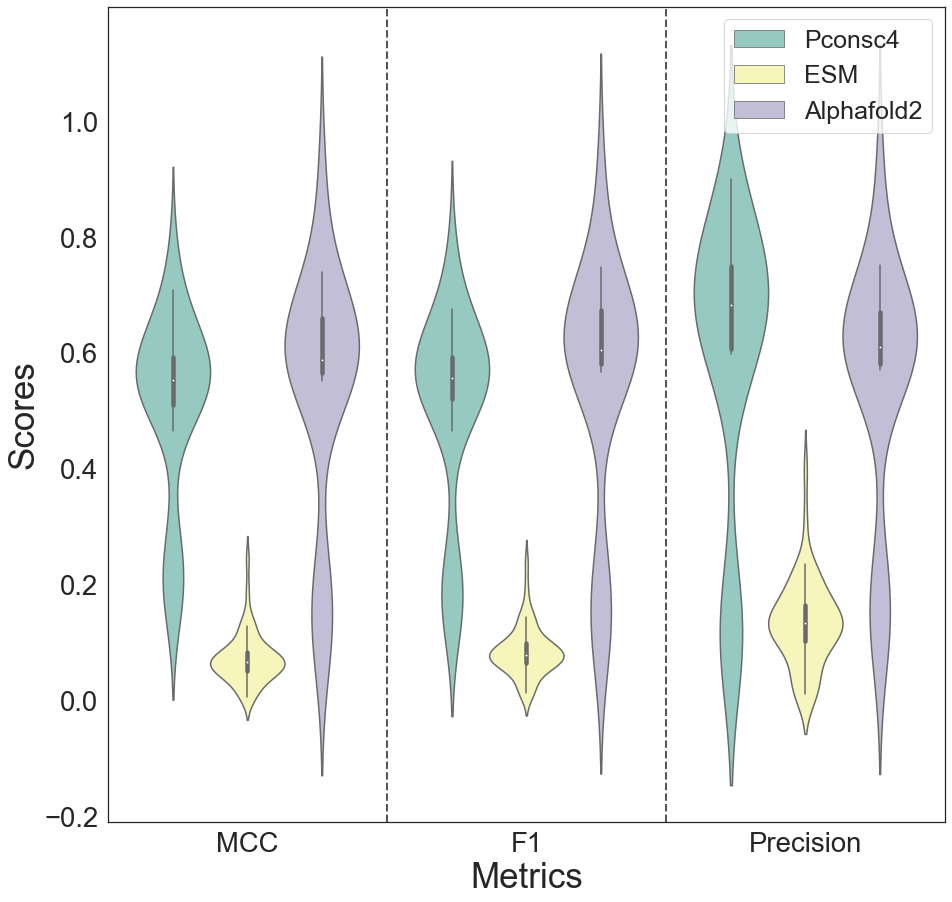

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set_style("white")
fig = plt.figure(figsize=(15, 15))

#adjust_box_widths(fig, 1)
# Define order of x-axis variables
metric_order = [ 'MCC', 'F1','Precision']

# Define order of hue variable (methods)
#hue_order = df_all_results['Method'].unique()
hue_order=['Pconsc4','ESM','Alphafold2']
# Create figure


# Create boxplot using seaborn
ax=sns.violinplot(x='variable', y='value', hue='Method', data=pd.melt(df_all_results[['Method', 'Precision', 'MCC', 'F1']], id_vars=['Method']), order=metric_order, palette="Set3", hue_order=hue_order,scale='width')

# Add vertical lines separating x-axis variables
for i in range(len(metric_order) - 1):
    ax.axvline(x=i + 0.5, ymin=0, ymax=1, color='#555555', linestyle='--', linewidth=2)

# Set labels and legend
ax.set_xlabel('Metrics', fontsize=35)
ax.set_ylabel('Scores', fontsize=35)
plt.legend(loc='upper right', fontsize=25)

# Show plot
plt.show()
fig.savefig(os.path.join('results',  'cmap_comparision' + '.png'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results',  'cmap_comparision' + '.pdf'), dpi=500, bbox_inches='tight')
fig.savefig(os.path.join('results',  'cmap_comparision' + '.svg'), dpi=500, bbox_inches='tight')

